Training a lightweight fallback model in memory for prediction.

--- Starting Fallback Model Training ---
Training RandomForestRegressor on 500 samples...
Fallback model training complete.
Generating batch data for 5 new prediction scenarios...

Input Data for Prediction:
|   feature_day_of_week |   feature_lag_1 |   feature_promo_flag |
|----------------------:|----------------:|---------------------:|
|                     6 |            85.5 |                    1 |
|                     7 |           120.1 |                    1 |
|                     1 |            40   |                    0 |
|                     2 |            62.3 |                    0 |
|                     5 |            99.8 |                    1 |

         BATCH DEMAND FORECAST RESULTS
|    |   feature_day_of_week |   feature_lag_1 |   feature_promo_flag |   FORECASTED_ORDERS |
|---:|----------------------:|----------------:|---------------------:|--------------------:|
|  0 |                     6 |

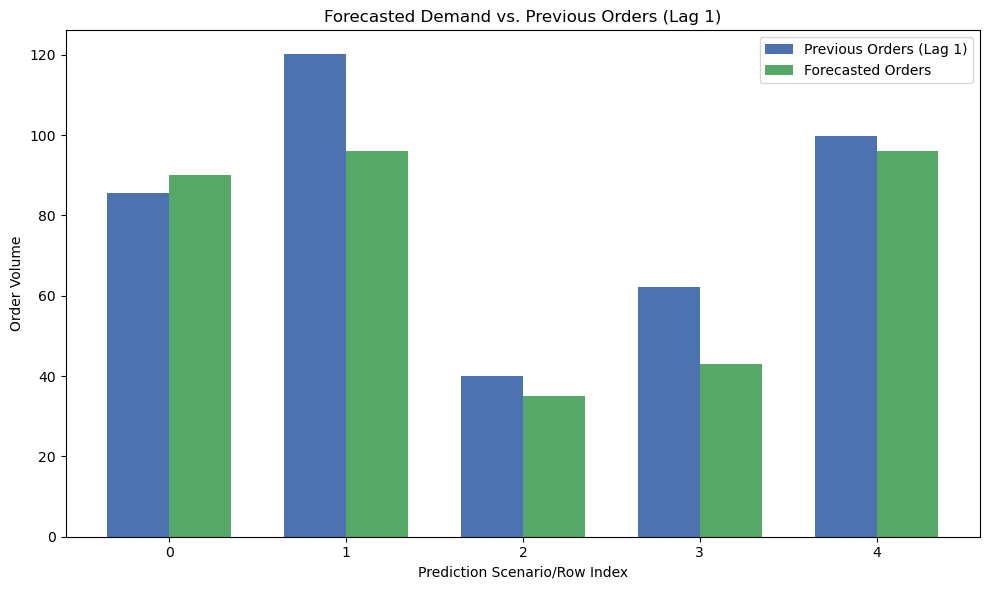

In [1]:
# This script loads the final trained model and generates a forecast
# for new, unseen supply chain data. It includes a fallback ML solution
# that trains a basic model if the production model file is missing.

import pickle
import pandas as pd
import numpy as np
import os
# New ML-related imports for the fallback solution
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# New visualization import
import matplotlib.pyplot as plt

# Define the expected path of the trained model file
MODEL_FILE_PATH = 'best_demand_forecast_model.pkl'

def train_fallback_model():
    """
    Trains a simple RandomForestRegressor model using synthetic data.
    This acts as a basic ML solution if the main, pre-trained model is missing.
    """
    print("\n--- Starting Fallback Model Training ---")
    
    # 1. Generate synthetic training data (must align with expected features)
    np.random.seed(42)
    n_samples = 500
    X_train = pd.DataFrame({
        'feature_day_of_week': np.random.randint(1, 8, n_samples),
        'feature_lag_1': np.random.rand(n_samples) * 100,
        'feature_promo_flag': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
    })
    # Simple linear relationship + noise for the target variable (orders)
    y_train = (10 + 
               X_train['feature_day_of_week'] * 3 + 
               X_train['feature_lag_1'] * 0.5 + 
               X_train['feature_promo_flag'] * 20 + 
               np.random.normal(0, 5, n_samples)
              )
    y_train = np.maximum(0, y_train) # Ensure non-negative orders

    # 2. Initialize and train the fallback model
    # Using a simple RandomForestRegressor for quick, effective training
    fallback_model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
    print(f"Training {type(fallback_model).__name__} on {n_samples} samples...")
    fallback_model.fit(X_train, y_train)
    
    print("Fallback model training complete.")
    return fallback_model


def load_model(file_path):
    """
    Loads the trained model from the specified file path.
    If the file is not found, it trains a fallback model instead.
    """
    if os.path.exists(file_path):
        try:
            with open(file_path, 'rb') as file:
                model = pickle.load(file)
            print(f"Successfully loaded production model: {type(model).__name__}")
            return model
        except Exception as e:
            print(f"Error loading the production model from '{file_path}': {e}")
            print("Falling back to in-memory training.")
            return train_fallback_model()
    else:
        print(f"Warning: Production model file '{file_path}' not found.")
        print("Training a lightweight fallback model in memory for prediction.")
        return train_fallback_model()

def prepare_new_data():
    """
    Creates a new DataFrame representing the input features for which
    we want to predict the demand (orders).
    
    NOTE: These features MUST match the features used during model training.
    """
    print("Generating batch data for 5 new prediction scenarios...")
    
    new_data = {
        # Feature 1: Day of the week (e.g., higher demand on 6/7 weekend days)
        'feature_day_of_week': [6, 7, 1, 2, 5], 
        
        # Feature 2: Lagged orders (orders from 1 period ago)
        # Assuming demand fluctuates from low (40) to high (120)
        'feature_lag_1': [85.5, 120.1, 40.0, 62.3, 99.8],
        
        # Feature 3: Promotion flag (1 if promo, 0 otherwise)
        'feature_promo_flag': [1, 1, 0, 0, 1] 
    }
    
    # Create a DataFrame for batch prediction
    new_df = pd.DataFrame(new_data)
    print("\nInput Data for Prediction:")
    print(new_df.to_markdown(index=False)) # Displaying as markdown for clean output
    return new_df

def make_prediction(model, new_data):
    """
    Generates a demand forecast using the loaded model. Returns a list
    of predictions for the input batch.
    """
    if model is None:
        print("Prediction failed: No model available.")
        return None
        
    try:
        # Generate the raw predictions for the entire batch
        raw_predictions = model.predict(new_data)
        
        # Post-processing: Demand/orders cannot be negative, and should be integers
        final_predictions = np.maximum(0, raw_predictions).astype(int)
        
        return final_predictions.tolist()
        
    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None

def visualize_forecast(results_df):
    """
    Generates a grouped bar chart comparing the previous period's orders 
    (Lag 1) vs. the new Forecasted Orders.
    """
    print("\nGenerating visualization...")
    
    # Set the positions for the bars
    x = np.arange(len(results_df))  
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Bar for Lagged Orders
    rects1 = ax.bar(x - width/2, results_df['feature_lag_1'], width, 
                    label='Previous Orders (Lag 1)', color='#4c72b0')
    
    # Bar for Forecasted Orders
    rects2 = ax.bar(x + width/2, results_df['FORECASTED_ORDERS'], width, 
                    label='Forecasted Orders', color='#55a868')

    # Add labels, title, and custom x-axis tick labels
    ax.set_ylabel('Order Volume')
    ax.set_xlabel('Prediction Scenario/Row Index')
    ax.set_title('Forecasted Demand vs. Previous Orders (Lag 1)')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df.index.to_list())
    ax.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# --- Main Execution ---

if __name__ == "__main__":
    
    # 1. Load the model (or train fallback)
    forecasting_model = load_model(MODEL_FILE_PATH)
    
    if forecasting_model:
        # 2. Prepare new data for forecasting
        data_to_predict = prepare_new_data()
        
        # 3. Make the forecast
        predicted_orders = make_prediction(forecasting_model, data_to_predict)
        
        # 4. Display results
        if predicted_orders is not None:
            # Create a results DataFrame combining input data and predictions
            results_df = data_to_predict.copy()
            results_df['FORECASTED_ORDERS'] = predicted_orders
            
            print("\n=================================================")
            print("         BATCH DEMAND FORECAST RESULTS")
            print("=================================================")
            print(results_df.to_markdown(index=True))
            print("=================================================")

            # 5. Visualize the results
            visualize_forecast(results_df)

        else:
            print("\nPrediction failed. Check error messages above.")
